<a href="https://colab.research.google.com/github/rajendranast012-stack/in-silico-lab1/blob/main/tanimoto_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install rdkit
!pip install pandas
!pip install seaborn
!pip install matplotlib

In [14]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from sklearn.cluster import KMeans

# --- Step 1: Load SMILES ---
df = pd.read_excel('/content/maccs.xlsx')  # adjust path
smiles_list = df['SMILES'].tolist()       # Replace 'SMILES' with your column name

# --- Step 2: Generate MACCS fingerprints ---
fps = []
valid_indices = []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps.append(fp)
        valid_indices.append(i)

n = len(fps)
print(f"Valid molecules: {n}")

Valid molecules: 187


In [24]:
# --- Step 3: Run K-means clustering ---
# Convert fingerprints to numpy arrays for K-means
fps_array = np.zeros((n, fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# Determine number of clusters (replace 4 with your best k)
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

In [25]:
# --- Step 4: Compute Tanimoto similarity matrix ---
sim_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

In [26]:
# --- Step 5: Sort molecules by cluster ---
sorted_indices = np.argsort(clusters)
sim_sorted = sim_matrix[np.ix_(sorted_indices, sorted_indices)]

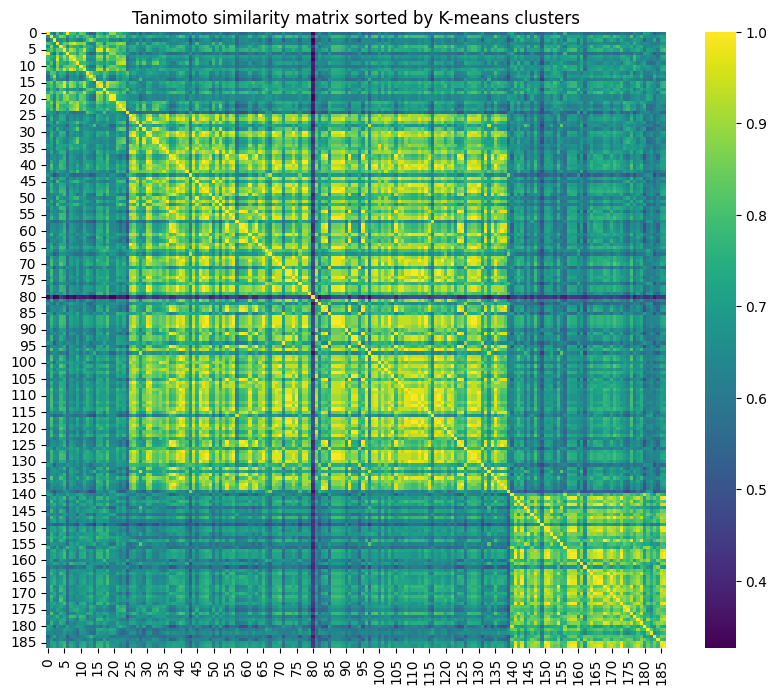

In [27]:
# --- Step 6: Plot heatmap ---
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()

In [28]:
import numpy as np

unique_clusters = np.unique(clusters)
for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    # within-cluster similarity
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_within = (np.sum(sims) - len(indices)) / (len(indices)*(len(indices)-1))
    print(f"Cluster {c}: Avg within-cluster Tanimoto = {avg_within:.3f}")


Cluster 0: Avg within-cluster Tanimoto = 0.760
Cluster 1: Avg within-cluster Tanimoto = 0.819
Cluster 2: Avg within-cluster Tanimoto = 0.823


for the scaffold, i.e. the most representative molecules


In [29]:
for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    print(f"Cluster {c} representative SMILES: {smiles_list[rep_idx]}")


Cluster 0 representative SMILES: CC1(C=CC2=C(C=CC(=C2O1)C3COC4=CC(=CC(=C4C3=O)O)O)O)C
Cluster 1 representative SMILES: COC1=CC(=C2C(=C1)OC(=C(C2=O)O)C3=CC(=C(C=C3)O)OC)O
Cluster 2 representative SMILES: CC(=CCC1=C(C=CC(=C1)C2=CC(=O)C3=C(C=C(C(=C3O2)CC=C(C)C)O)O)O)C


Cluster 0 representative SMILES: CC1(C=CC2=C(C=CC(=C2O1)C3COC4=CC(=CC(=C4C3=O)O)O)O)C
Cluster 1 representative SMILES: COC1=CC(=C2C(=C1)OC(=C(C2=O)O)C3=CC(=C(C=C3)O)OC)O
Cluster 2 representative SMILES: CC(=CCC1=C(C=CC(=C1)C2=CC(=O)C3=C(C=C(C(=C3O2)CC=C(C)C)O)O)O)C


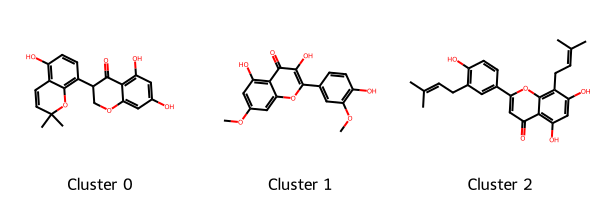

In [31]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Load SMILES and cluster info ---
df = pd.read_excel('/content/maccs.xlsx')  # adjust path
smiles_list = df['SMILES'].tolist()

# --- Generate MACCS fingerprints ---
fps = []
valid_indices = []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

# --- K-means clustering (replace with your best k) ---
fps_array = np.zeros((len(fps), fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

best_k = 3  # replace with your silhouette-optimal k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --- Compute Tanimoto similarity matrix ---
n = len(fps)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --- Find representative molecules per cluster ---
representatives = []
unique_clusters = np.unique(clusters)

for c in unique_clusters:
    indices = np.where(clusters == c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    representatives.append(rep_idx)
    print(f"Cluster {c} representative SMILES: {smiles_list[rep_idx]}")

# --- Draw representative molecules ---
rep_mols = [Chem.MolFromSmiles(smiles_list[i]) for i in representatives]
img = Draw.MolsToGridImage(rep_mols, molsPerRow=best_k, subImgSize=(200,200), legends=[f"Cluster {c}" for c in unique_clusters])
display(img)


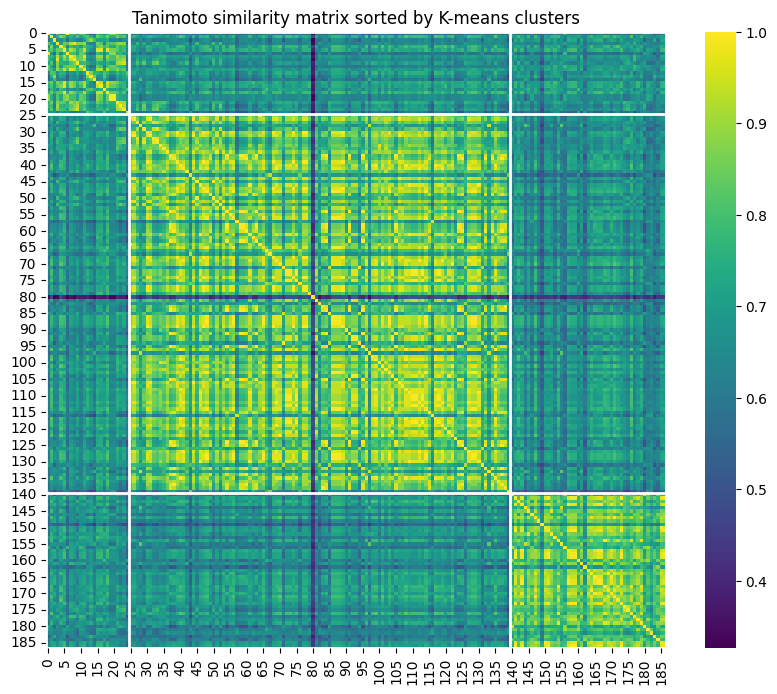

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
# Draw lines to separate clusters
cum_sizes = [0] + [np.sum(clusters==c) for c in unique_clusters]
for s in np.cumsum(cum_sizes):
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()


one whole script

Valid molecules: 187


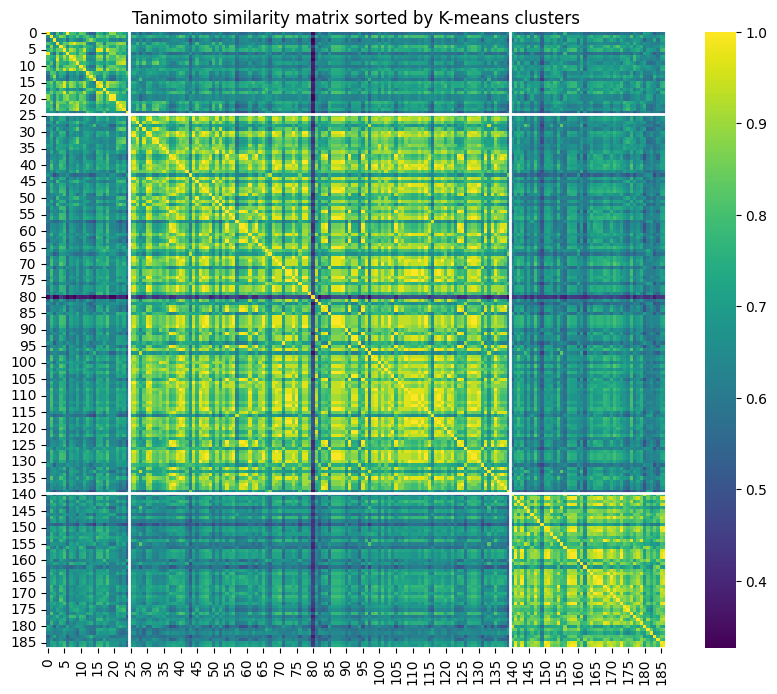

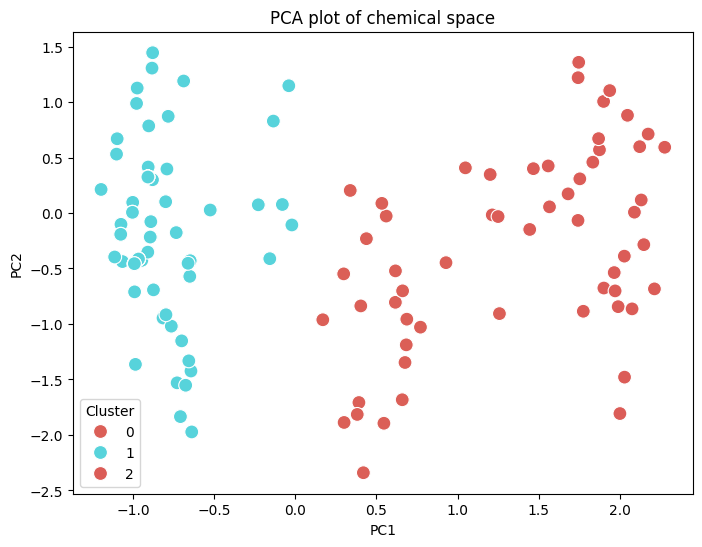

Cluster 0 representative SMILES: CC1(C=CC2=C(C=CC(=C2O1)C3COC4=CC(=CC(=C4C3=O)O)O)O)C
Cluster 1 representative SMILES: COC1=CC(=C2C(=C1)OC(=C(C2=O)O)C3=CC(=C(C=C3)O)OC)O
Cluster 2 representative SMILES: CC(=CCC1=C(C=CC(=C1)C2=CC(=O)C3=C(C=C(C(=C3O2)CC=C(C)C)O)O)O)C


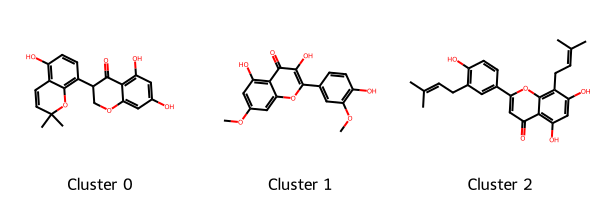

In [33]:
# ==========================
# Flavonoid Clustering & Visualization Workflow
# ==========================

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, Draw
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Step 1: Load SMILES
# --------------------------
df = pd.read_excel('/content/maccs.xlsx')  # Adjust your path
smiles_list = df['SMILES'].tolist()        # Ensure column name is 'SMILES'

# --------------------------
# Step 2: Generate MACCS fingerprints
# --------------------------
fps = []
valid_indices = []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        fps.append(MACCSkeys.GenMACCSKeys(mol))
        valid_indices.append(i)

n = len(fps)
print(f"Valid molecules: {n}")

# --------------------------
# Step 3: Convert fingerprints to numpy array for K-means
# --------------------------
fps_array = np.zeros((n, fps[0].GetNumBits()), dtype=int)
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, fps_array[i])

# --------------------------
# Step 4: Determine best k (from silhouette)
# --------------------------
best_k = 3  # Replace with your silhouette-optimal k

# --------------------------
# Step 5: Run K-means clustering
# --------------------------
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(fps_array)

# --------------------------
# Step 6: Compute Tanimoto similarity matrix
# --------------------------
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        sim_matrix[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

# --------------------------
# Step 7: Sort matrix by cluster
# --------------------------
sorted_indices = np.argsort(clusters)
sim_sorted = sim_matrix[np.ix_(sorted_indices, sorted_indices)]

# --------------------------
# Step 8: Plot Tanimoto heatmap
# --------------------------
plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')
# Draw lines to separate clusters
cum_sizes = np.cumsum([np.sum(clusters==c) for c in range(best_k)])
for s in cum_sizes:
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)
plt.title('Tanimoto similarity matrix sorted by K-means clusters')
plt.show()

# --------------------------
# Step 9: PCA 2D scatter colored by cluster
# --------------------------
pca = PCA(n_components=2)
coords = pca.fit_transform(fps_array)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=clusters, palette='hls', s=100)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA plot of chemical space")
plt.legend(title="Cluster")
plt.show()

# --------------------------
# Step 10: Identify representative molecules per cluster
# --------------------------
representatives = []
unique_clusters = np.unique(clusters)

for c in unique_clusters:
    indices = np.where(clusters == c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    representatives.append(rep_idx)
    print(f"Cluster {c} representative SMILES: {smiles_list[rep_idx]}")

# --------------------------
# Step 11: Draw representative molecules
# --------------------------
rep_mols = [Chem.MolFromSmiles(smiles_list[i]) for i in representatives]
img = Draw.MolsToGridImage(rep_mols, molsPerRow=best_k, subImgSize=(200,200),
                           legends=[f"Cluster {c}" for c in unique_clusters])
display(img)

# --------------------------
# Step 12: Save cluster info and statistics
# --------------------------
df_clusters = pd.DataFrame({'SMILES': smiles_list, 'Cluster': clusters})
df_clusters.to_excel("cluster_assignments.xlsx", index=False)

# Cluster-level average within-cluster Tanimoto
avg_within = []
for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    sims = sim_matrix[np.ix_(indices, indices)]
    avg = (np.sum(sims) - len(indices)) / (len(indices)*(len(indices)-1))  # exclude diagonal
    avg_within.append((c, avg))

avg_df = pd.DataFrame(avg_within, columns=['Cluster','Avg_Tanimoto_within'])
avg_df.to_excel("cluster_similarity_summary.xlsx", index=False)


In [34]:
import pandas as pd

# Create a label list for sorted molecules
cluster_labels_sorted = clusters[sorted_indices]

# Example: print first 10 to see which cluster
print(cluster_labels_sorted[:10])


[0 0 0 0 0 0 0 0 0 0]


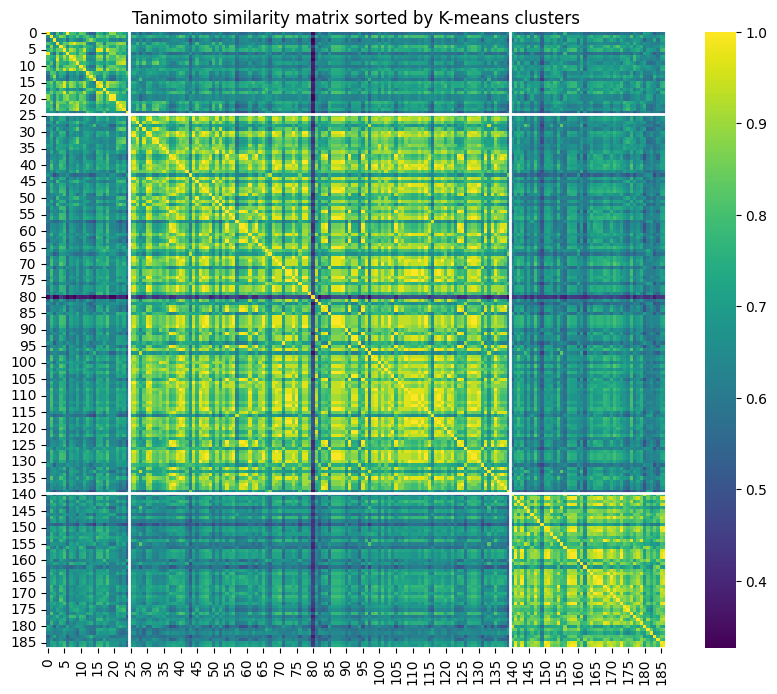

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(sim_sorted, cmap='viridis')

# Draw cluster boundaries if you want
for s in cum_sizes:
    plt.axhline(s, color='white', lw=2)
    plt.axvline(s, color='white', lw=2)

plt.title('Tanimoto similarity matrix sorted by K-means clusters')

# Save figure to file
plt.savefig("tanimoto_heatmap.png", dpi=300, bbox_inches='tight')  # dpi=300 for high quality
plt.show()


summemry of hte cluster

In [36]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors

unique_clusters = np.unique(clusters)

for c in unique_clusters:
    indices = np.where(clusters==c)[0]
    print(f"\nCluster {c} summary:")

    # 1. Number of molecules
    print(f"Number of molecules: {len(indices)}")

    # 2. Representative molecule
    sims = sim_matrix[np.ix_(indices, indices)]
    avg_sims = np.mean(sims, axis=1)
    rep_idx = indices[np.argmax(avg_sims)]
    print(f"Representative SMILES: {smiles_list[rep_idx]}")

    # 3. Average molecular weight and LogP
    mols = [Chem.MolFromSmiles(smiles_list[i]) for i in indices]
    mw = [Descriptors.MolWt(m) for m in mols]
    logp = [Descriptors.MolLogP(m) for m in mols]
    print(f"Avg MolWt: {np.mean(mw):.2f}, Avg LogP: {np.mean(logp):.2f}")

    # 4. Draw representative molecule
    Draw.MolToImage(mols[np.argmax(avg_sims)])



Cluster 0 summary:
Number of molecules: 25
Representative SMILES: CC1(C=CC2=C(C=CC(=C2O1)C3COC4=CC(=CC(=C4C3=O)O)O)O)C
Avg MolWt: 351.41, Avg LogP: 3.94

Cluster 1 summary:
Number of molecules: 115
Representative SMILES: COC1=CC(=C2C(=C1)OC(=C(C2=O)O)C3=CC(=C(C=C3)O)OC)O
Avg MolWt: 319.20, Avg LogP: 2.67

Cluster 2 summary:
Number of molecules: 47
Representative SMILES: CC(=CCC1=C(C=CC(=C1)C2=CC(=O)C3=C(C=C(C(=C3O2)CC=C(C)C)O)O)O)C
Avg MolWt: 382.24, Avg LogP: 4.13
